# V-10 flight simulation
This notebook is being developed by the avionics and flight dynamics sub-teams in The Rocket Launchers student organization at the University of Texas Rio Grande Valley. Our rocket's name is V-10 in celebration of our club's 10th anniversary! V-10 will be competing in the 10k COTS division at Lonestar cup 2026 and IREC 2026.


Key features of V-10:
- Air brakes
- vonKarman Nose Cone
- Replaceable fins


In [1]:
# Import RocketPy classes for simulation components
# Environment: atmospheric conditions and launch site
# SolidMotor: rocket motor thrust and geometry
# Rocket: main rocket assembly with mass and aerodynamic properties
# Flight: flight simulation engine
# Aerodynamic surfaces: TrapezoidalFins, EllipticalFins, NoseCone, Tail
# Recovery: Parachute
# Rail components: RailButtons
from rocketpy import Environment, SolidMotor, Rocket, Flight, TrapezoidalFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
import datetime

## Environment

The Environment object simulates real-world atmospheric conditions and geographic location for accurate flight trajectory predictions.

**Location Variables:**
- `launch_latitude`: geographic latitude in degrees (positive = North, negative = South)
- `launch_longitude`: geographic longitude in degrees (positive = East, negative = West)  
- `launch_elevation`: altitude of launch site above mean sea level in meters

**Why Location Matters:**
Geographic location affects the simulation through:
- **Gravity variations**: gravitational acceleration varies slightly with latitude (centrifugal effects)
- **Atmospheric density**: elevation determines initial air density at launch
- **Weather patterns**: GFS forecast data is location-specific
- **Earth rotation effects**: Coriolis forces influence trajectory at different latitudes

**Atmospheric Model:**
The environment uses **GFS (Global Forecast System)** weather forecast data to provide realistic atmospheric conditions throughout the flight:
- **Air density (ρ)**: decreases exponentially with altitude, directly affects drag force magnitude
- **Temperature (T)**: affects speed of sound (a = √(γRT)) and therefore Mach number calculations
- **Pressure (P)**: influences air density through ideal gas law (ρ = P/RT)
- **Wind velocity**: causes trajectory drift and affects relative airspeed

**Drag Force Dependency:**
All atmospheric properties feed into the drag force equation:  
**F_drag = 0.5 × ρ(altitude) × v_relative² × Cd(Mach) × A_ref**

where air density ρ varies with altitude according to the atmospheric model, and Mach number depends on local temperature.

**V-10 Launch Sites:**
- **Rocket Ranch** (Seymour, TX): Primary testing location - currently configured
- **IREC** (Spaceport America, Las Cruces, NM): Competition site for June 2026

In [2]:
# Create environment object and configure launch site location
env = Environment()

# ==================== LAUNCH SITE CONFIGURATIONS ====================
# V-10 Mission Launch Sites

# Launch Site 1: Rocket Ranch - Seymour, Texas (Primary Testing Location)
# Used for: Pre-competition test flights, airbrakes testing, recovery validation
rocket_ranch_latitude = 33.49862509998744   # degrees North
rocket_ranch_longitude = -99.3376124767802  # degrees West
rocket_ranch_elevation = 417.0  # meters above sea level (approximate)

# Launch Site 2: Spaceport America - Las Cruces, New Mexico (IREC Competition)
# Used for: Intercollegiate Rocket Engineering Competition (IREC) June 2026
spaceport_america_latitude = 32.990254   # degrees North
spaceport_america_longitude = -106.974998  # degrees West
spaceport_america_elevation = 1400.0  # meters above sea level

# ==================== ACTIVE LAUNCH SITE ====================
# Currently configured for: ROCKET RANCH (Seymour, TX)
launch_latitude = rocket_ranch_latitude
launch_longitude = rocket_ranch_longitude
launch_elevation = rocket_ranch_elevation

# Set environment to active launch site
env.set_location(latitude=launch_latitude, longitude=launch_longitude)
env.set_elevation(launch_elevation)

print(f"Launch site configured: Rocket Ranch, Seymour, TX")
print(f"Coordinates: {launch_latitude}°N, {launch_longitude}°W")
print(f"Elevation: {launch_elevation} m ASL")

Launch site configured: Rocket Ranch, Seymour, TX
Coordinates: 33.49862509998744°N, -99.3376124767802°W
Elevation: 417.0 m ASL


Optionally, you can set the date and atmospheric model


In [3]:
# Set simulation date to tomorrow at noon (12:00)
# Uses GFS (Global Forecast System) atmospheric model for realistic weather conditions
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type='Forecast', file='GFS')


Gravity Details

Acceleration of gravity at surface level:    9.7790 m/s²
Acceleration of gravity at  78.948 km (ASL): 9.5411 m/s²


Launch Site Details

Launch Date: 2025-11-01 12:00:00 UTC
Launch Site Latitude: 33.49863°
Launch Site Longitude: -99.33761°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 416.7 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 78.948 km
Forecast Time Period: from 2025-10-31 18:00:00 to 2025-11-16 18:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 4.12 m/s
Surface Wind Direction: 127.44°
Surface Wind Heading: 307.44°
Surface Pressure: 966.54 hPa
Surface Temperature: 285.95 K
Surface Air Density: 1.178 kg/m³
Surface Speed of Sound: 338.99 m/s


Earth Model Details

Earth Radius at Launch site:

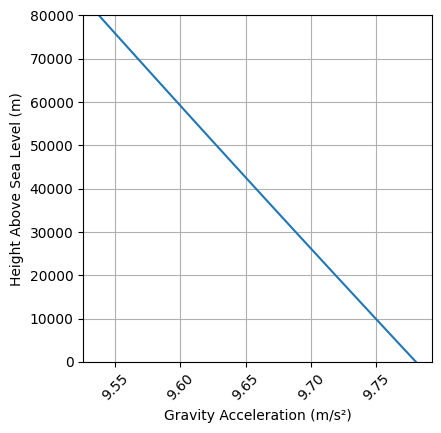



Atmospheric Model Plots


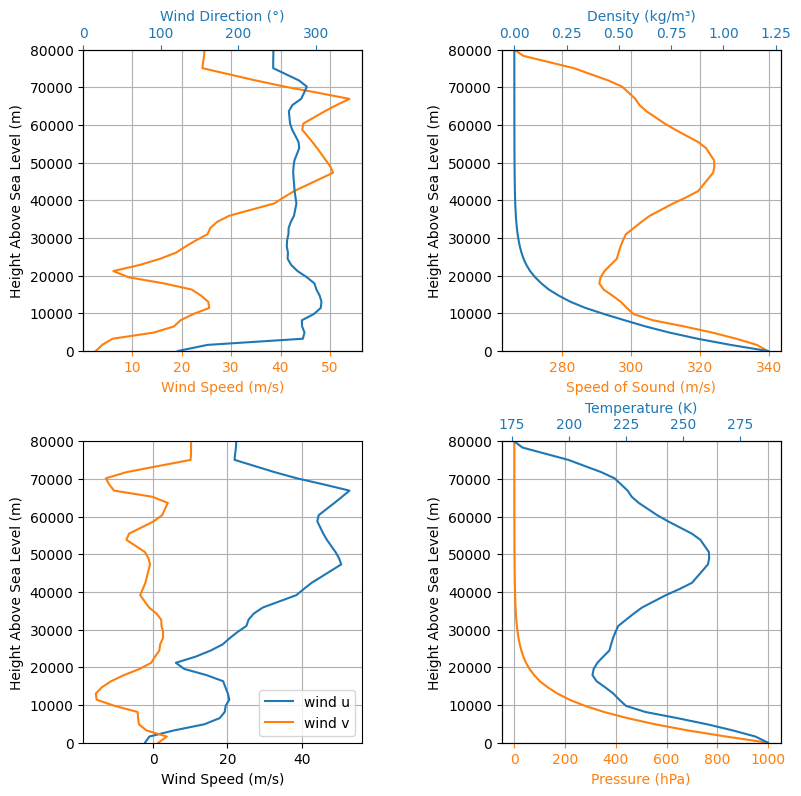

In [4]:
# Display complete environment information including:
# - Launch site coordinates and elevation
# - Date and time of simulation
# - Atmospheric conditions (temperature, pressure, wind)
# - Weather model data source
env.all_info()

## Motor

V-10 uses an AeroTech M2500T (98 mm) solid motor. The motor configuration includes:

**Geometry Variables:**
- `motor_grain_outer_radius`: outer radius of propellant grain
- `motor_grain_inner_radius`: inner hollow core radius  
- `motor_grain_height`: axial length of propellant grain
- `motor_nozzle_radius`: nozzle exit radius
- `motor_throat_radius`: nozzle throat radius (minimum flow area)

**Mass Variables:**
- `motor_dry_mass`: mass of motor casing without propellant
- `motor_grain_density`: propellant density used to calculate propellant mass

**Position:**
- `motor_nozzle_position`: distance from grain center to nozzle

The thrust curve is loaded from the local ENG file. Motor orientation is set to `combustion_chamber_to_nozzle` to align with the rocket's coordinate system.

In [5]:
# Motor geometry and mass parameters
motor_dry_mass = 3.353  # kg - motor casing mass without propellant
motor_grain_density = 1137.5  # kg/m³ - propellant density
motor_grain_outer_radius = 0.049  # m - outer diameter of propellant grain (98 mm motor)
motor_grain_inner_radius = 0.0245  # m - inner hollow core radius
motor_grain_height = 0.732  # m - length of propellant grain
motor_nozzle_radius = 0.036750000000000005  # m - nozzle exit radius
motor_throat_radius = 0.0245  # m - nozzle throat radius (minimum diameter)
motor_nozzle_position = 0.351  # m - distance from grain center to nozzle

# Create SolidMotor object with AeroTech M2500T specifications
m2500t = SolidMotor(
    thrust_source='../../data/AeroTech_M2500T.eng',
    dry_mass=motor_dry_mass,
    center_of_dry_mass_position=0,
    dry_inertia=[0, 0, 0],
    grains_center_of_mass_position=0,
    grain_number=1,
    grain_density=motor_grain_density,
    grain_outer_radius=motor_grain_outer_radius,
    grain_initial_inner_radius=motor_grain_inner_radius,
    grain_initial_height=motor_grain_height,
    grain_separation=0,
    nozzle_radius=motor_nozzle_radius,
    nozzle_position=motor_nozzle_position,
    throat_radius=motor_throat_radius,
    reshape_thrust_curve=False,
    interpolation_method='linear',
    coordinate_system_orientation='combustion_chamber_to_nozzle',
)

Nozzle Details
Nozzle Radius: 0.036750000000000005 m
Nozzle Throat Radius: 0.0245 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 1137.5 kg/m3
Grain Outer Radius: 0.049 m
Grain Inner Radius: 0.0245 m
Grain Height: 0.732 m
Grain Volume: 0.004 m3
Grain Mass: 4.710 kg

Motor Details
Total Burning Time: 3.9021 s
Total Propellant Mass: 4.710 kg
Structural Mass Ratio: 0.416
Average Propellant Exhaust Velocity: 1922.523 m/s
Average Thrust: 2320.807 N
Maximum Thrust: 4080.53093197668 N at 2.40567201759911 s after ignition.
Total Impulse: 9056.021 Ns



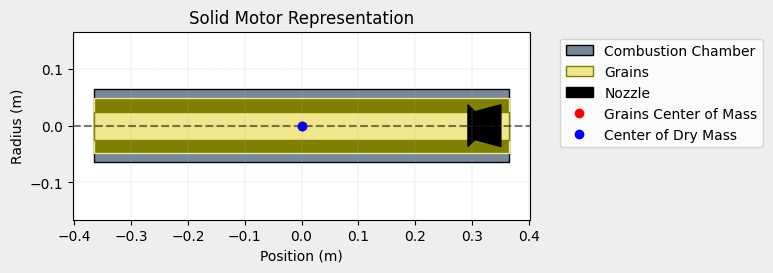

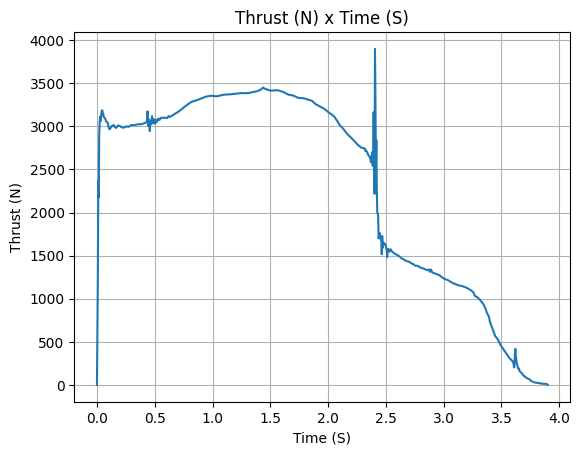

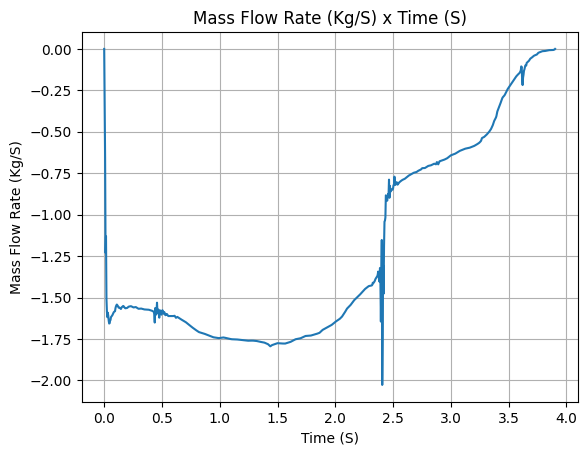

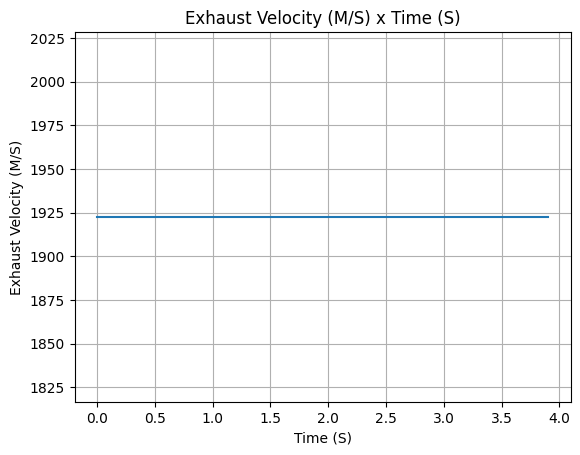

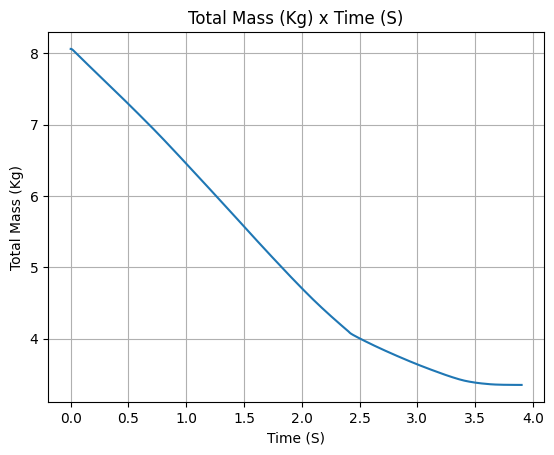

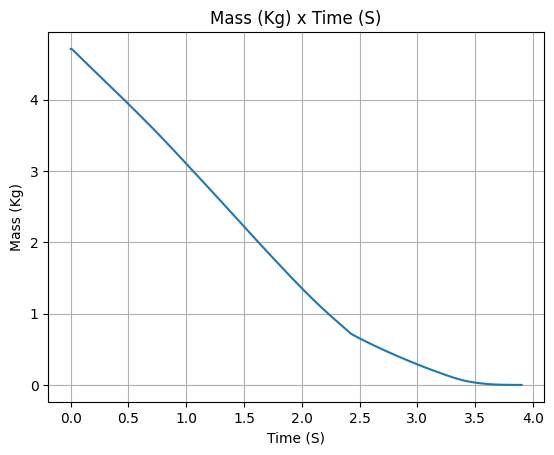

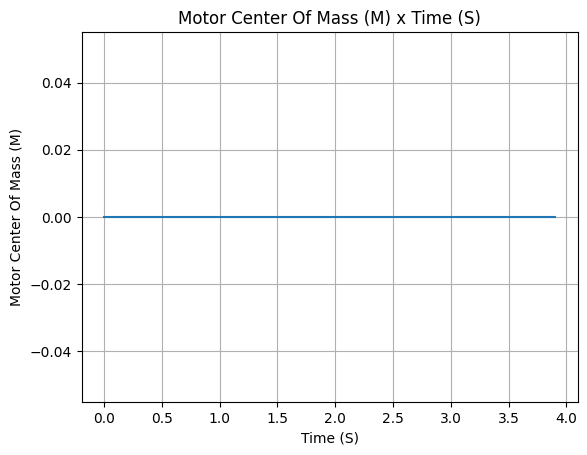

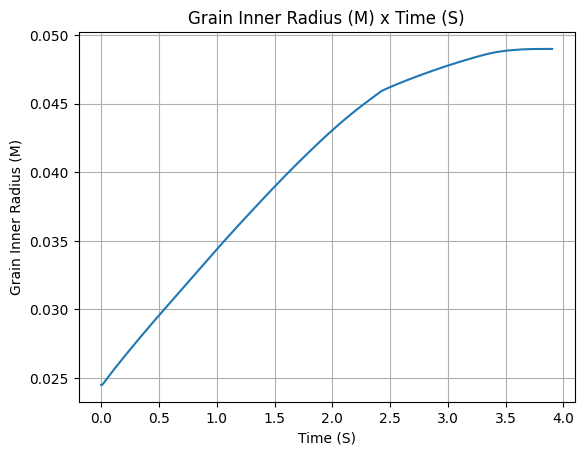

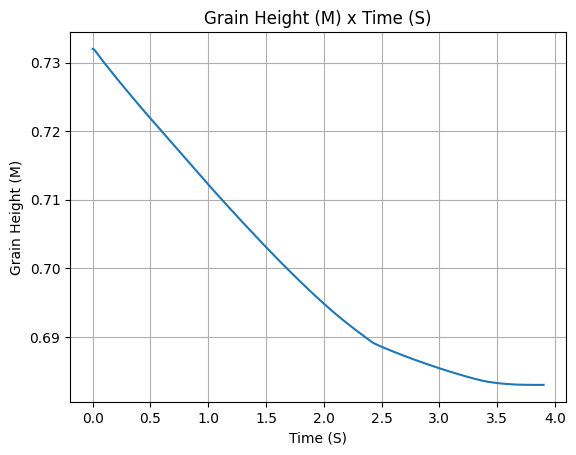

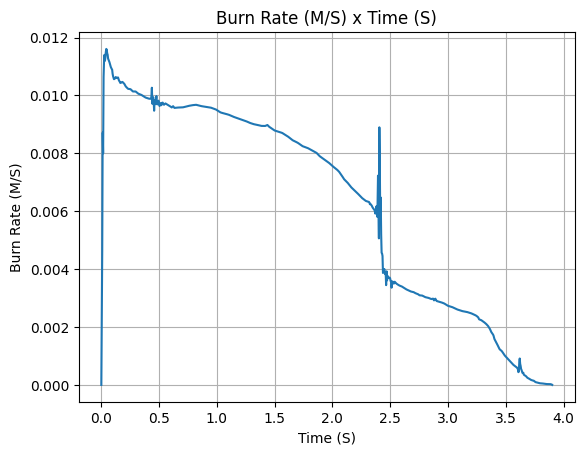

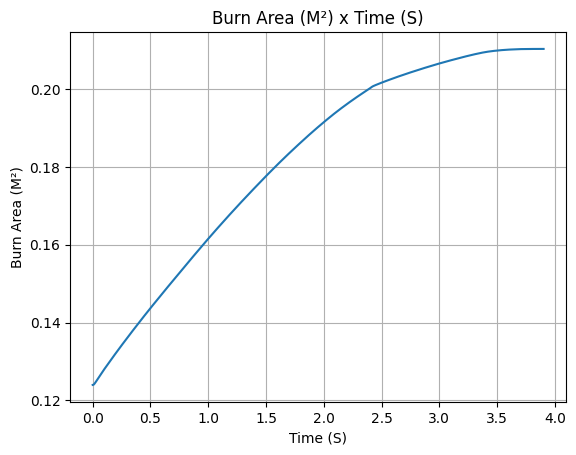

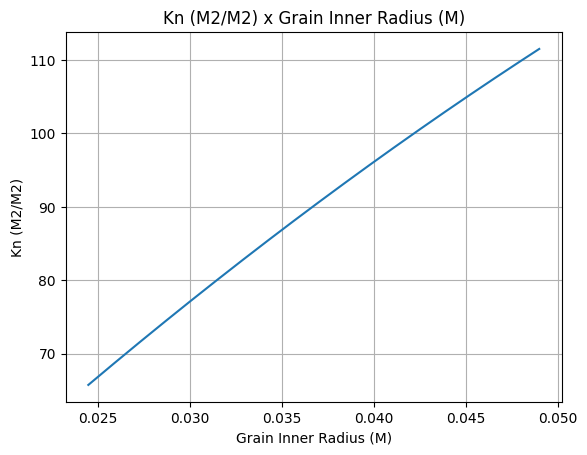

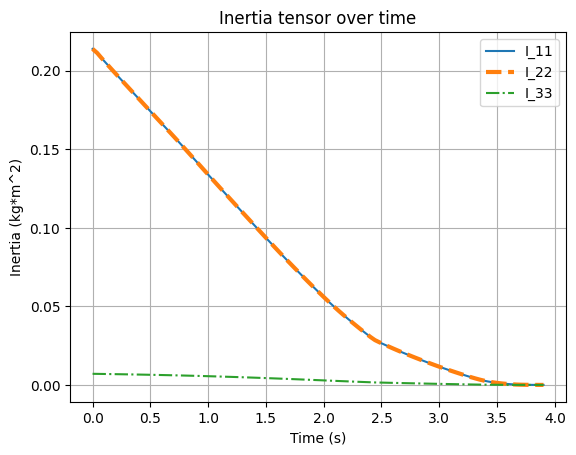

In [6]:
# Display complete motor information including:
# - Thrust curve and performance characteristics
# - Grain geometry and mass properties
# - Nozzle dimensions
# - Center of mass evolution during burn
m2500t.all_info()

## Rocket Assembly

V-10 is a single-stage rocket. The rocket assembly combines aerodynamic surfaces with mass/inertia properties and drag models.

**Key Dimensional Variables:**
- `rocket_body_radius`: reference radius defining the main body tube diameter and reference area for drag calculations

**Mass Properties:**
- `rocket_dry_mass`: total rocket mass without motor
- `rocket_com_without_motor`: center of mass position from nose tip (without motor)
- `rocket_inertia_i`: moment of inertia about pitch/yaw axes (Ixx = Iyy)
- `rocket_inertia_z`: moment of inertia about roll axis (Izz)

**Drag Models:**
- `cd_power_off`: drag coefficient vs Mach number after motor burnout
- `cd_power_on`: drag coefficient vs Mach number during motor burn

The coordinate system uses `nose_to_tail` orientation, with positive distances measured from the nose tip toward the tail.

Next, we define individual aerodynamic surfaces (nose cone, fins, boat tail) before assembling the complete rocket.

### Nose Cone

V-10 uses a **Von Kármán (Haack series)** nose cone optimized for minimum drag at supersonic speeds.

**Dimensional Variables:**
- `nosecone_length`: axial length from tip to base
- `nosecone_base_radius`: radius at the base (matches body tube)
- `rocket_body_radius`: main body tube radius for proper attachment

**Drag Contribution:**
The Von Kármán shape minimizes **wave drag** at supersonic speeds by optimizing the volume distribution along the nose. This reduces the strength of shock waves formed at the nose tip during high-speed flight. The nose cone contributes to the overall rocket drag coefficient through:
- **Form drag**: shape-dependent pressure distribution
- **Wave drag**: shock wave formation at supersonic speeds (minimized by Von Kármán profile)
- **Skin friction drag**: surface friction along the nose cone length

In [7]:
# Nose cone dimensions
nosecone_length = 0.381  # m - length from tip to base
nosecone_base_radius = 0.0777875  # m - radius at the base (matches body tube)
rocket_body_radius = 0.0777875  # m - main body tube radius

# Create Von Karman nose cone (optimized for minimum drag at supersonic speeds)
# The Von Karman shape minimizes wave drag and is ideal for high-speed flight
nosecone = NoseCone(
    length=nosecone_length,
    kind='Von Karman',
    base_radius=nosecone_base_radius,
    rocket_radius=rocket_body_radius,
    name='Nose Cone',
)

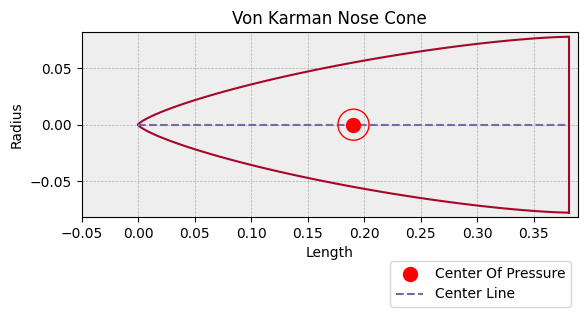

In [8]:
# Display nose cone profile visualization
# Shows the aerodynamic shape and dimensions
nosecone.draw()

### Fins

V-10 features trapezoidal fins for aerodynamic stability. The fin geometry is approximated from the V-10 freeform design.

**Fin Dimensional Variables:**
- `fin_count`: number of fins around the body
- `fin_root_chord`: length of fin along the body (root attachment)
- `fin_tip_chord`: length of fin at the outer tip
- `fin_span`: height of fin perpendicular to body (extends radially outward)
- `fin_sweep_length`: horizontal distance from root leading edge to tip leading edge (determines sweep angle)

**Drag Contribution:**
Fins contribute to drag through multiple mechanisms:
- **Skin friction drag**: surface area of fin exposed to airflow
- **Form drag**: pressure drag from fin thickness and profile
- **Induced drag**: generated when fins produce lift at angle of attack (stabilizing the rocket)
- **Interference drag**: additional drag at the fin-body junction due to flow interaction
- **Wave drag** (supersonic): shock waves formed at fin leading edges and body-fin junctions

The fin sweep angle (determined by `fin_sweep_length`) helps reduce wave drag at supersonic speeds by angling the leading edge relative to the airflow.

In [9]:
# Fin dimensions (trapezoidal approximation of V-10 fin design)
fin_count = 4  # number of fins
fin_root_chord = 0.3048  # m - length of fin at the root (attached to body)
fin_tip_chord = 0.01905  # m - length of fin at the tip
fin_span = 0.1524  # m - height of fin (perpendicular to body)
fin_sweep_length = 0.254  # m - horizontal distance from root leading edge to tip leading edge

# Create trapezoidal fins
# Fins provide aerodynamic stability and generate lift-induced drag
# Drag contribution: form drag from fin thickness, induced drag from lift at angle of attack
fins = TrapezoidalFins(
    n=fin_count,
    root_chord=fin_root_chord,
    tip_chord=fin_tip_chord,
    span=fin_span,
    sweep_length=fin_sweep_length,
    rocket_radius=rocket_body_radius,
    name="CF Trapezoidal (approx from V-10)",
)

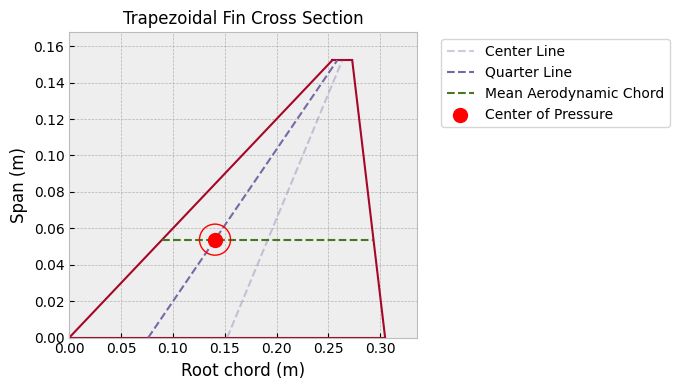

In [10]:
# Display fin planform (top-down view) showing geometry
# Visualizes the trapezoidal shape with sweep angle
fins.draw()

### Transitions (Tails)

The boat tail is a conical transition at the rocket's aft end that reduces base drag.

**Boat Tail Dimensional Variables:**
- `boattail_top_radius`: radius at the forward end (matches main body tube)
- `boattail_bottom_radius`: smaller radius at the aft end
- `boattail_length`: axial length of the transition

**Drag Contribution:**
The boat tail serves to reduce **base drag** (pressure drag in the wake region). Key effects:
- **Base pressure recovery**: the tapered shape helps streamline airflow, reducing the low-pressure wake region behind the rocket
- **Flow separation control**: gradual diameter reduction delays or controls boundary layer separation
- **Wave drag reduction** (supersonic): smoother geometric transition reduces shock strength at the aft end

Without a boat tail, the blunt base would create significant pressure drag due to flow separation and wake formation. The conical taper (`boattail_top_radius` to `boattail_bottom_radius`) allows the flow to close more gradually, increasing base pressure and reducing overall drag.

In [11]:
# Initialize dictionary to store tail/transition sections
# Tails create aerodynamic transitions between different body diameters
tails = {}

In [12]:
# Boat tail dimensions (conical transition at rocket aft end)
boattail_top_radius = 0.0777875  # m - matches main body tube radius
boattail_bottom_radius = 0.0635  # m - smaller radius at aft end
boattail_length = 0.0508  # m - axial length of transition

# Create boat tail component
# Boat tail reduces base drag by smoothing airflow transition at the rocket's aft end
# Helps reduce pressure drag in the wake region behind the rocket
tails[0] = Tail(
    top_radius=boattail_top_radius,
    bottom_radius=boattail_bottom_radius,
    length=boattail_length,
    rocket_radius=rocket_body_radius,
    name='Boat Tail',
)

### Parachutes

V-10 uses a two-stage recovery system with drogue and main parachutes.

**Parachute Drag Variables:**

**Main Parachute:**
- `main_chute_cd`: drag coefficient of the main parachute canopy
- `main_chute_diameter`: diameter when fully inflated
- `main_chute_area`: reference area (π × (diameter/2)²)
- `main_chute_cd_s`: effective drag area (Cd × area), used directly in drag force calculation
- `main_deploy_altitude`: altitude trigger for deployment

**Drogue Parachute:**
- `drogue_chute_cd`: drag coefficient of the drogue parachute
- `drogue_chute_diameter`: smaller diameter for controlled descent
- `drogue_chute_area`: reference area
- `drogue_chute_cd_s`: effective drag area

**Drag Force Calculation:**
Parachute drag force follows: **F_drag = 0.5 × ρ × v² × CdS**

where `CdS` is the product of drag coefficient and reference area. The drogue deploys at apogee to stabilize and slow initial descent, while the main parachute deploys at lower altitude for safe landing.

In [13]:
# Initialize dictionary to store parachute recovery components
parachutes = {}

In [14]:
# Main parachute drag parameters
main_chute_cd = 2.2  # Drag coefficient for parachute canopy
main_chute_diameter = 2.7432  # m - parachute diameter when fully inflated
main_chute_area = 3.14159 * (main_chute_diameter / 2) ** 2  # m² - reference area
main_chute_cd_s = main_chute_cd * main_chute_area  # m² - effective drag area (CdS)
main_deploy_altitude = 396.24  # m - deployment altitude above ground level

# Create main parachute with deployment trigger
# CdS (drag coefficient × area) determines the drag force: F_drag = 0.5 × ρ × v² × CdS
parachutes[0] = Parachute(
    name='Main Parachute + Bag',
    cd_s=main_chute_cd_s,
    trigger=main_deploy_altitude,
    sampling_rate=100, 
)

In [15]:
# Drogue parachute drag parameters
drogue_chute_cd = 2.2  # Drag coefficient for drogue parachute
drogue_chute_diameter = 0.6096  # m - smaller diameter for initial descent stabilization
drogue_chute_area = 3.14159 * (drogue_chute_diameter / 2) ** 2  # m² - reference area
drogue_chute_cd_s = drogue_chute_cd * drogue_chute_area  # m² - effective drag area (CdS)

# Create drogue parachute that deploys at apogee (highest point)
# Drogue slows descent and stabilizes rocket before main chute deployment
parachutes[1] = Parachute(
    name='Drogue',
    cd_s=drogue_chute_cd_s,
    trigger='apogee',
    sampling_rate=100, 
)

### Rocket Drag Coefficients

The rocket's total drag is characterized by **drag coefficient (Cd)** as a function of Mach number. We define separate curves for:
- **Power-off drag** (`cd_power_off`): drag after motor burnout
- **Power-on drag** (`cd_power_on`): drag during motor burn (includes base drag effects from exhaust plume)

Drag varies with Mach number due to:
- **Subsonic (M < 0.9)**: primarily skin friction and form drag from body and fins
- **Transonic (0.9 < M < 1.2)**: wave drag increases dramatically near M=1 due to shock formation
- **Supersonic (M > 1.2)**: wave drag from nose cone, body, and fins dominates

The `rocket_body_radius` defines the reference area (A_ref = π × radius²) used in drag force calculation:  
**F_drag = 0.5 × ρ × v² × Cd × A_ref**

Below we define Cd vs Mach arrays with initial estimates. These should be refined with CFD analysis or flight data.

### Applying CFD Analysis to Drag Coefficients

**For Flight Dynamics Team: How to Use CFD Results**

When you obtain drag coefficients from Computational Fluid Dynamics (CFD) analysis, you need to understand what to simulate and how to apply the results to this flight simulation.

#### Option 1: Full Rocket CFD (Recommended for Accuracy)

**What to simulate:** 
- Complete rocket assembly including nose cone, body tube, fins, and boat tail as a single geometry
- Run simulations across Mach numbers: 0.0, 0.5, 0.9, 1.0, 1.2, 2.0, 3.0 (minimum)
- Simulate both power-on (with exhaust plume) and power-off configurations

**How to apply results:**
1. Extract total Cd values at each Mach number from CFD post-processing
2. Create [Mach, Cd] pairs from your CFD data
3. Replace the `cd_power_off` and `cd_power_on` arrays with your CFD results
4. The rocket reference area is automatically calculated from `rocket_body_radius`

**Advantages:**
- Most accurate - captures all interaction effects between components
- Accounts for interference drag at fin-body and nose-body junctions
- Includes base drag effects and wake interactions
- No need to combine separate component drag values

**CFD Setup Requirements:**
- Include exhaust plume geometry/boundary condition for power-on case
- Ensure proper boundary layer resolution (y+ < 1 for accurate skin friction)
- Use compressible flow solver for transonic/supersonic regimes

---

#### Option 2: Component-by-Component CFD (More Work, Educational)

**What to simulate:**
- Nose cone alone (cone + cylindrical body section)
- Fins alone (single fin or fin set on cylinder)
- Boat tail alone (transition geometry)

**How to apply results:**
If you choose this approach, you'll need to:
1. Get Cd values for each component at each Mach number
2. Calculate total Cd by **summing** component contributions (with caution)
3. Apply correction factors for interference drag (typically 5-15% increase)

**Important Notes:**
- **RocketPy already models individual surfaces** (nose cone, fins, tail) internally
- The `cd_power_off` and `cd_power_on` arrays represent the **total rocket Cd**
- If using component CFD, you're essentially validating/improving RocketPy's built-in models
- Component drag values **do not add linearly** - you must account for:
  - **Interference drag**: additional drag at component junctions
  - **Mutual flow interaction**: fins affect body flow, nose affects fin flow
  - **Wake effects**: upstream components affect downstream drag

**This approach is NOT recommended** unless you're conducting detailed aerodynamic studies, because:
- More simulations required (3-4× the computational cost)
- Must manually combine results with interference factors
- RocketPy's geometric methods already provide good component estimates
- Full-rocket CFD gives better results with less effort

---

#### Option 3: Hybrid Approach (Component Validation)

**Recommended workflow:**
1. Run **full rocket CFD** to get total Cd values → use for flight simulation
2. Run **component CFD** separately to validate and understand contributions
3. Compare component CFD to RocketPy's internal component drag breakdown
4. Use insights to refine rocket geometry for drag reduction

---

#### Updating Drag Coefficients with CFD Data

**Example:** If your CFD analysis produces these results:

```python
# CFD-derived drag coefficients (example data)
cd_power_off_cfd = np.array([
    [0.00, 0.42],  # Your CFD result at M=0.0
    [0.50, 0.48],  # Your CFD result at M=0.5
    [0.90, 0.54],  # Your CFD result at M=0.9
    [1.00, 0.78],  # Your CFD result at M=1.0 (transonic peak)
    [1.20, 0.63],  # Your CFD result at M=1.2
    [2.00, 0.49],  # Your CFD result at M=2.0
])
```

Simply replace the current `cd_power_off` array with your CFD data. The simulation will interpolate between your data points.

---

#### Critical CFD Considerations

**Reference Area:**
- Ensure your CFD Cd is based on **body cross-sectional area** (π × `rocket_body_radius`²)
- RocketPy uses body area as reference, not fin area or wetted area
- If your CFD uses a different reference area, convert: Cd_body = Cd_other × (A_other / A_body)

**Mach Number Range:**
- Cover subsonic (M < 0.9), transonic (0.9-1.2), and supersonic (M > 1.2) regimes
- Transonic region (M ≈ 1.0) shows highest drag - ensure fine resolution here
- V-10 will likely experience M = 0 to ~2.5 during flight

**Power-On vs Power-Off:**
- **Power-on**: exhaust plume reduces base drag significantly (5-10% lower total Cd)
- **Power-off**: larger wake region increases base drag
- Model power-on with appropriate exhaust plume pressure/temperature boundary conditions

**Validation:**
- Compare CFD results to empirical methods (Barrowman, RASAero, OpenRocket)
- Check that Cd increases dramatically at M ≈ 1.0 (wave drag)
- Verify Cd decreases at higher supersonic Mach numbers
- Transonic peak should be Cd ≈ 0.7-0.8 for typical rockets

---

#### Current Drag Coefficients Status

The `cd_power_off` and `cd_power_on` arrays currently contain **initial estimates** based on typical rocket aerodynamics. These should be replaced with CFD-derived values for accurate flight predictions.

In [16]:
import numpy as np

# Drag coefficient vs Mach number curves for V-10 rocket
# Each row: [Mach number, Cd value]
# These are initial estimates and should be refined with CFD or flight test data

# Power-off drag (after motor burnout) - higher base drag without exhaust plume
cd_power_off = np.array([
    [0.00, 0.45],  # Subsonic: skin friction + form drag
    [0.50, 0.50],  # High subsonic
    [0.90, 0.55],  # Transonic approach: drag rise begins
    [1.00, 0.75],  # Transonic peak: maximum wave drag at sonic speed
    [1.20, 0.65],  # Supersonic: wave drag from shocks
    [2.00, 0.50],  # High supersonic: drag decreases
    [3.00, 0.45],  # Hypersonic approach
])

# Power-on drag (during motor burn) - reduced base drag due to exhaust plume filling wake
cd_power_on = np.array([
    [0.00, 0.40],  # Subsonic with thrust
    [0.50, 0.45],  # High subsonic
    [0.90, 0.50],  # Transonic approach
    [1.00, 0.70],  # Transonic peak: wave drag maximum
    [1.20, 0.60],  # Supersonic
    [2.00, 0.45],  # High supersonic
    [3.00, 0.40],  # Hypersonic approach
])

# Rocket mass and dimensional properties
rocket_dry_mass = 17.732  # kg - mass without motor
rocket_inertia_i = 0.115  # kg⋅m² - moment of inertia about pitch axis (Ixx = Iyy)
rocket_inertia_z = 21.424  # kg⋅m² - moment of inertia about roll axis (Izz)
rocket_com_without_motor = 0.0  # m - center of mass position (will be set as origin)

# ⚠️ CRITICAL FIX: Changed from 'nose_to_tail' to 'tail_to_nose'
# This ensures Z+ points UP (from tail toward nose) for correct flight simulation
# With tail_to_nose: component positions will be NEGATIVE toward tail from nose

# Create Rocket object with aerodynamic and mass properties
# The reference radius determines reference area for drag force calculations
rocket = Rocket(
    radius=rocket_body_radius,
    mass=rocket_dry_mass,
    inertia=[rocket_inertia_i, rocket_inertia_i, rocket_inertia_z],
    power_off_drag=cd_power_off,
    power_on_drag=cd_power_on,
    center_of_mass_without_motor=rocket_com_without_motor,
    coordinate_system_orientation='tail_to_nose',  # ✅ CORRECT: Z+ points UP
)

### Adding surfaces to the rocket

We attach aerodynamic surfaces at specific axial positions (measured from nose tip):
- **Nose cone** at position `nosecone_position`: the tip reference point
- **Fins** at position `fins_position`: root leading edge location
- **Boat tail** at position `boattail_position`: start of aft transition

Proper positioning is critical for accurate center of pressure and stability margin calculations. All positions follow the 'nose_to_tail' coordinate convention (positive direction toward tail).

In [17]:
# Axial positions for aerodynamic surfaces
# ⚠️ UPDATED for 'tail_to_nose' coordinate system
# With tail_to_nose: Z+ points UP (from tail to nose)
# - Nose at Z=0 (origin at nose tip)
# - Components toward tail have NEGATIVE Z positions

nosecone_position = 0.0     # m - nose cone tip is the origin (reference point)
fins_position = -2.592      # m - root leading edge of fins (toward tail = negative)
boattail_position = -2.8964  # m - start of boat tail transition (toward tail = negative)

# Add all aerodynamic surfaces to the rocket at their specified positions
# This affects center of pressure calculation and overall stability
rocket.add_surfaces(surfaces=[nosecone, fins, tails[0]], positions=[nosecone_position, fins_position, boattail_position])

In [18]:
# Motor position (aft end of motor casing measured from nose tip)
# ⚠️ UPDATED for 'tail_to_nose' coordinate system
# Motor is toward tail, so position is NEGATIVE
motor_position = -2.562  # m - motor placement in airframe (toward tail = negative)

# Add motor to rocket
# Motor position affects center of mass location and mass distribution
rocket.add_motor(m2500t, position=motor_position)

Adding parachutes to the rocket


In [19]:
# Assign parachutes to rocket recovery system
# Converts dictionary to list and adds to rocket object
rocket.parachutes = list(parachutes.values())

### Rail Buttons

Rail buttons guide the rocket along the launch rail until sufficient velocity is achieved for aerodynamic stability. Positions are defined as:
- `upper_button_position`: distance from nose tip to upper button center
- `lower_button_position`: distance from nose tip to lower button center
- `angular_position`: rotational position around the body (degrees)

Proper spacing ensures smooth rail departure and prevents rail whip during launch.

In [20]:
# Rail button positions (measured from nose tip)
# ⚠️ UPDATED for 'tail_to_nose' coordinate system
# Rail buttons are toward tail, so positions are NEGATIVE
upper_button_position = -1.7778  # m - upper button center location (toward tail = negative)
lower_button_position = -1.3906  # m - lower button center location (toward tail = negative)
button_angular_position = 60.0   # degrees - rotational position around body

# Configure rail buttons on the rocket
# Rail buttons engage with launch rail to provide initial guidance
rail_buttons = rocket.set_rail_buttons(
   upper_button_position=upper_button_position,
   lower_button_position=lower_button_position,
   angular_position=button_angular_position,
)


Inertia Details

Rocket Mass: 17.732 kg (without motor)
Rocket Dry Mass: 21.085 kg (with unloaded motor)
Rocket Loaded Mass: 25.795 kg
Rocket Structural Mass Ratio: 0.817
Rocket Inertia (with unloaded motor) 11: 18.624 kg*m2
Rocket Inertia (with unloaded motor) 22: 18.624 kg*m2
Rocket Inertia (with unloaded motor) 33: 21.424 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0777875 m
Rocket Frontal Area: 0.019009 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.407 m
Rocket Center of Dry Mass - Nozzle Exit: 2.506 m
Rocket Center of Dry Mass - Center of Propellant Mass: 2.155 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.393 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
CF Trapezoidal (approx from V-10) Lift Coefficient Derivative:

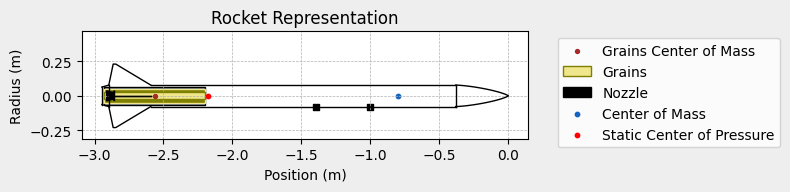


Mass Plots
----------------------------------------


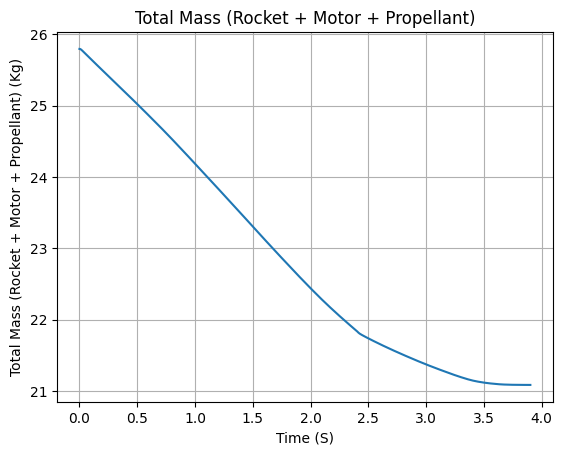

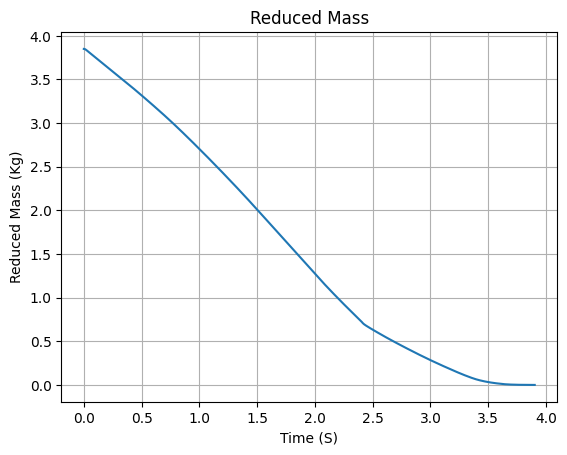


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


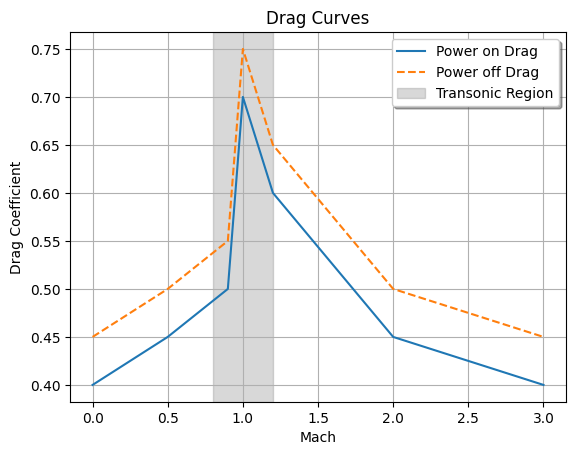


Stability Plots
--------------------


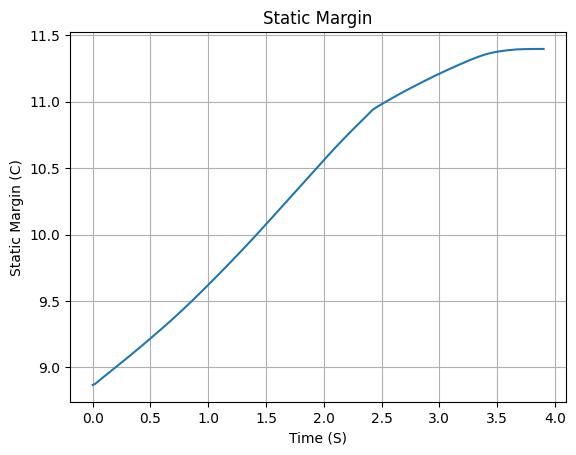

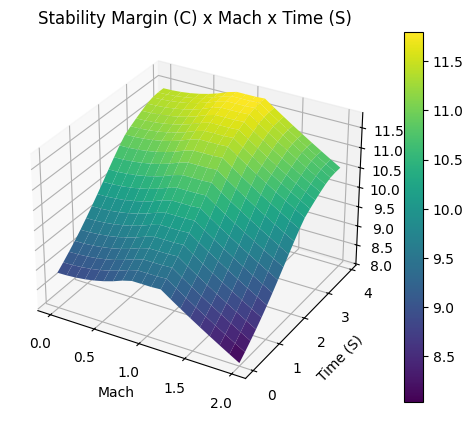


Thrust-to-Weight Plot
----------------------------------------


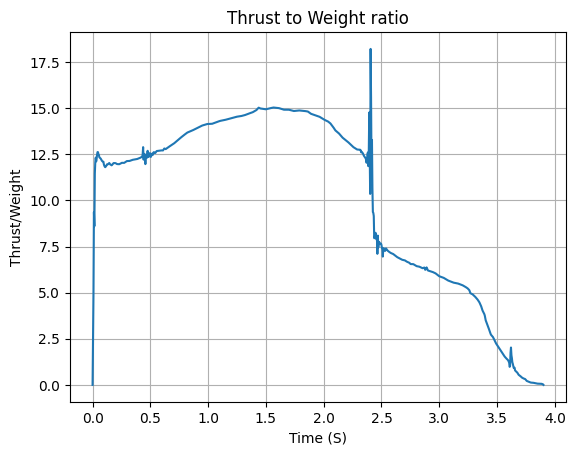

In [21]:
# Display comprehensive rocket information including:
# - Mass properties (total mass, center of mass, inertia)
# - Aerodynamic properties (drag curves, surface contributions)
# - Geometric configuration (dimensions, component positions)
# - Stability analysis (center of pressure, static margin)
rocket.all_info()

## Flight Simulation

Now we create the flight simulation object with launch parameters:
- `rail_length`: length of launch rail in meters
- `inclination`: launch angle from horizontal (90° = vertical)
- `heading`: compass direction (0° = North, 90° = East)
- `max_time`: maximum simulation duration in seconds

The simulation integrates equations of motion considering thrust, drag, gravity, and aerodynamic forces.

In [22]:
# Flight simulation parameters
rail_length = 5.1816  # m - length of launch rail
launch_inclination = 90.0  # degrees - vertical launch (90° from horizontal)
launch_heading = 90.0  # degrees - East direction (compass heading)
max_simulation_time = 600  # seconds - maximum flight time to simulate

# Create Flight simulation object
# Simulates rocket trajectory from launch through descent and landing
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=rail_length,
    inclination=launch_inclination,
    heading=launch_heading,
    terminate_on_apogee=False,  # Continue simulation through descent
    max_time=max_simulation_time,
)

Flight Summary:

Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 416.70 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.966 | e1: 0.000 | e2: 0.000 | e3: -0.259
Euler Angles - Spin φ : -195.00° | Nutation θ: 0.00° | Precession ψ: 165.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 8.868 c


Surface Wind Conditions

Frontal Surface Wind Speed: -3.07 m/s
Lateral Surface Wind Speed: 2.69 m/s


Launch Rail

Launch Rail Length: 5.1816 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.255 s
Rail Departure Velocity: 26.562 m/s
Rail Departure Stability Margin: 9.044 c
Rail Departure Angle of Attack: 8.880°
Rail Departure Thrust-Weight Ratio: 12.035
Rail Departure Reynolds Number: 2.768e+05


Burn out State

Burn out time: 3.902 s
Altitude at burn out: 1204.649 m (ASL) | 787.953 m (AGL)
Rocket speed at burn out: 300.1

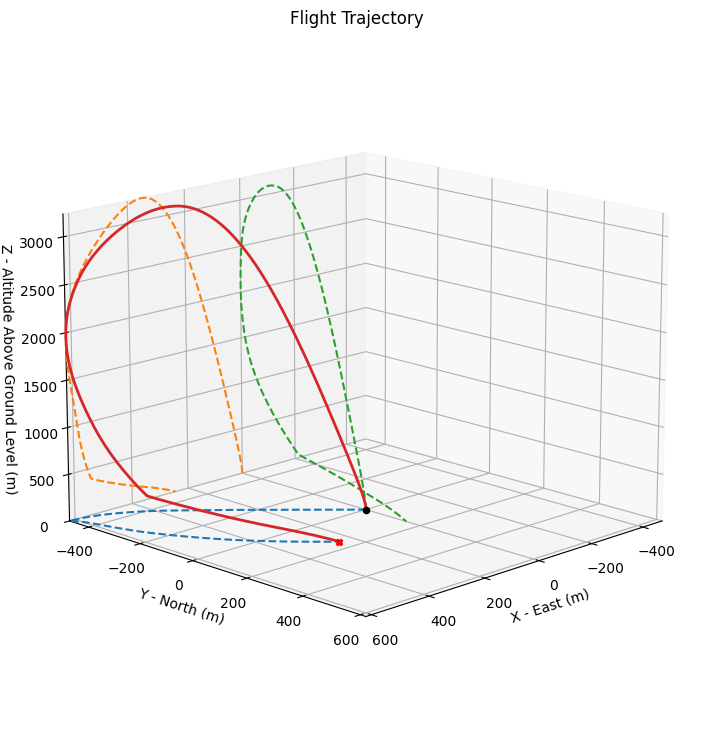



Trajectory Kinematic Plots



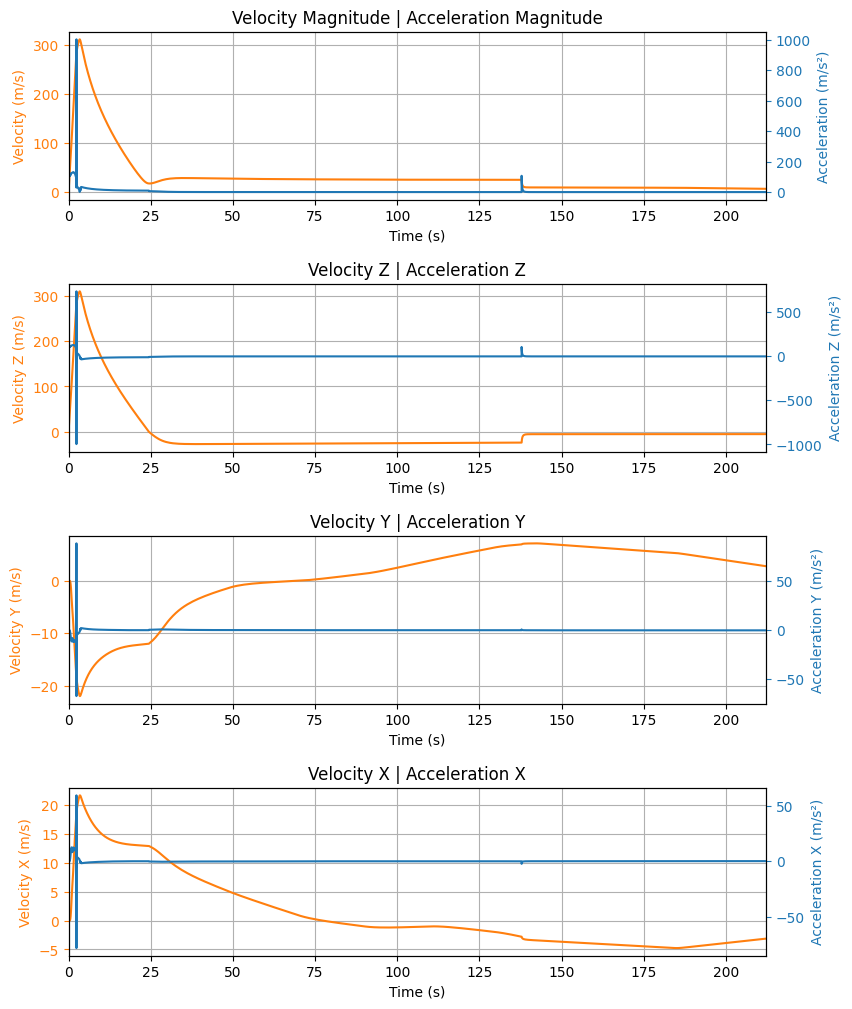



Angular Position Plots



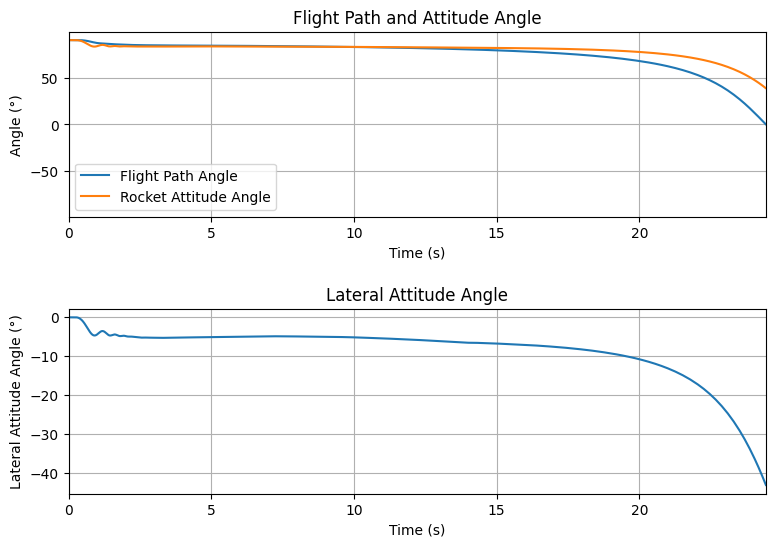



Path, Attitude and Lateral Attitude Angle plots



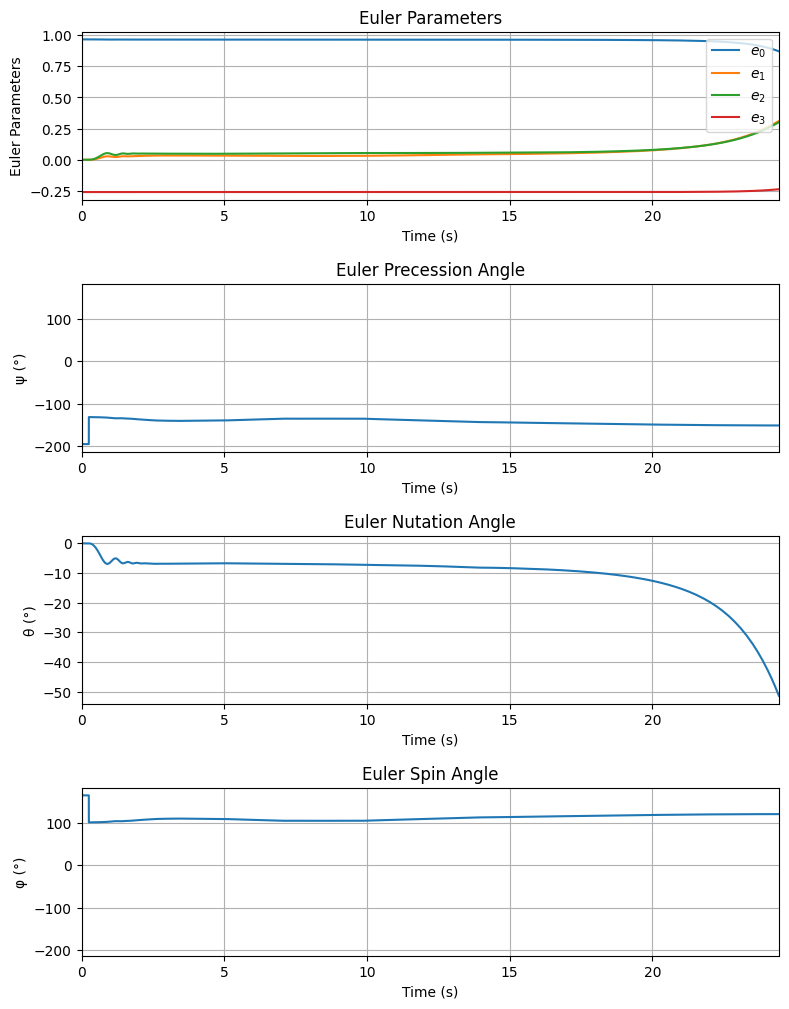



Trajectory Angular Velocity and Acceleration Plots



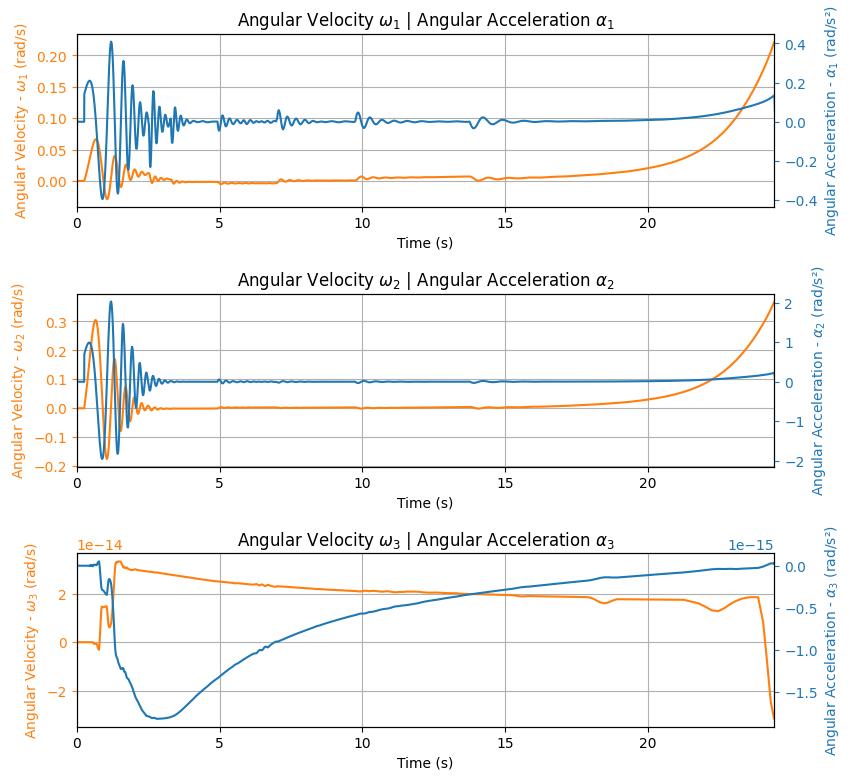



Aerodynamic Forces Plots



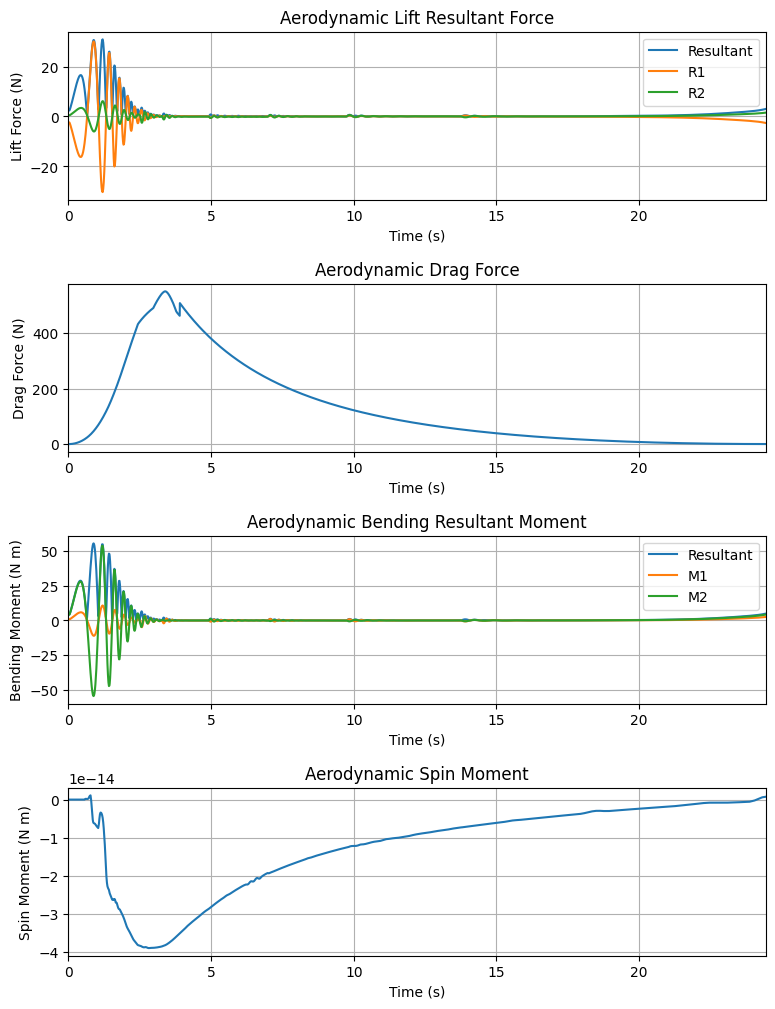



Rail Buttons Forces Plots



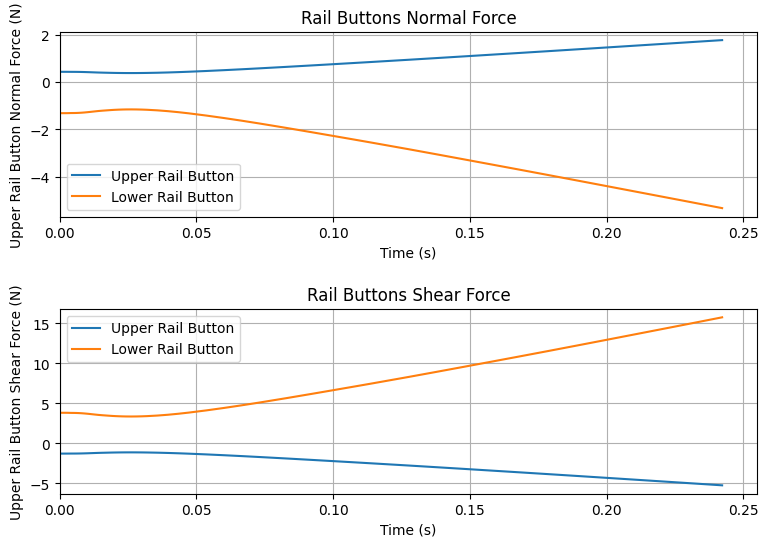



Trajectory Energy Plots



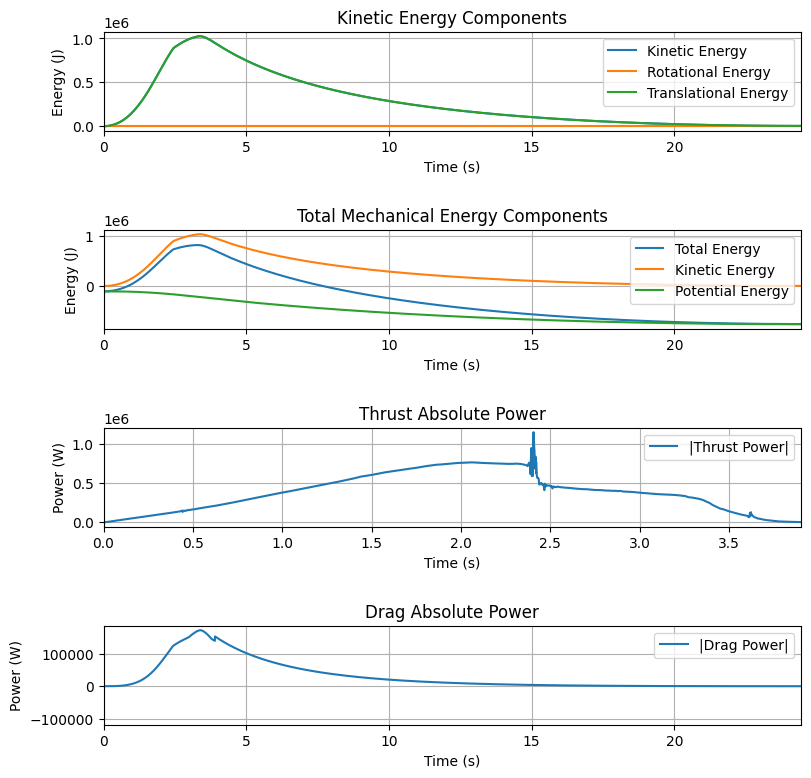



Trajectory Fluid Mechanics Plots



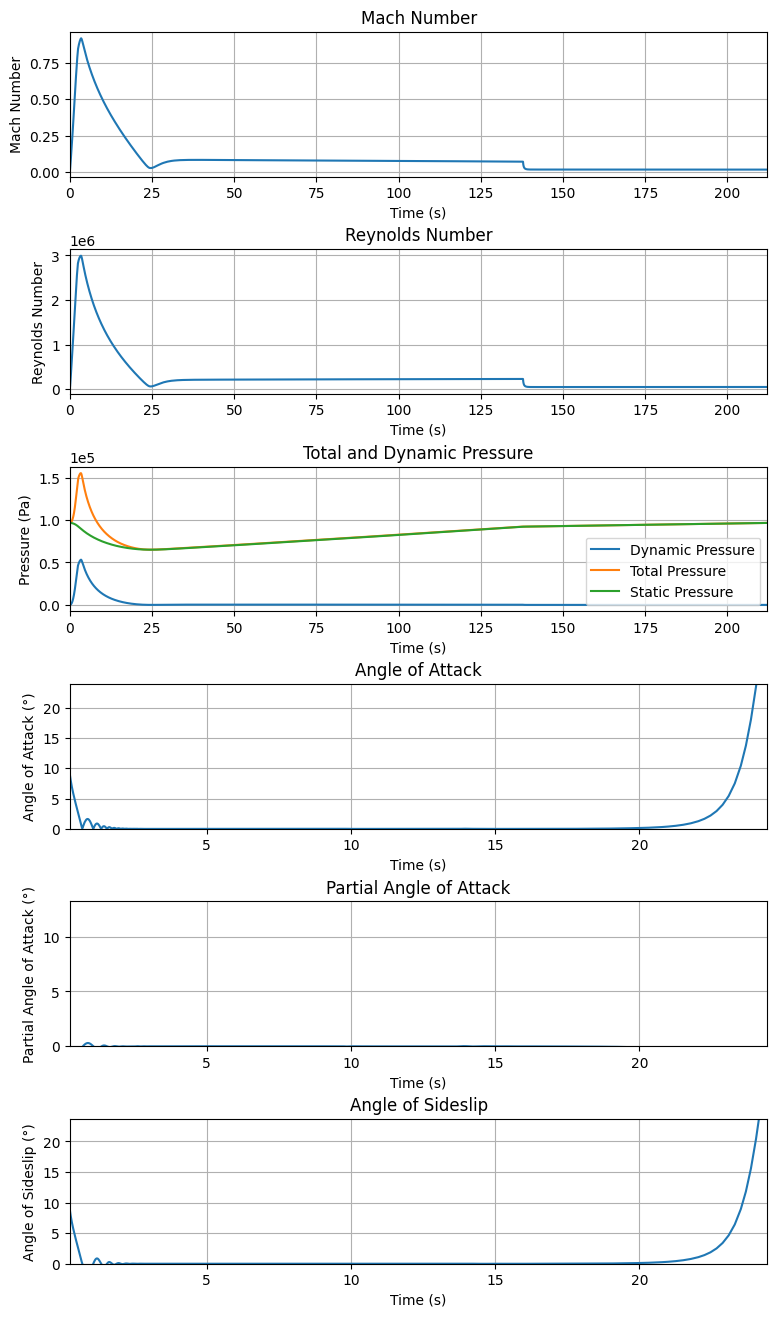



Trajectory Stability and Control Plots



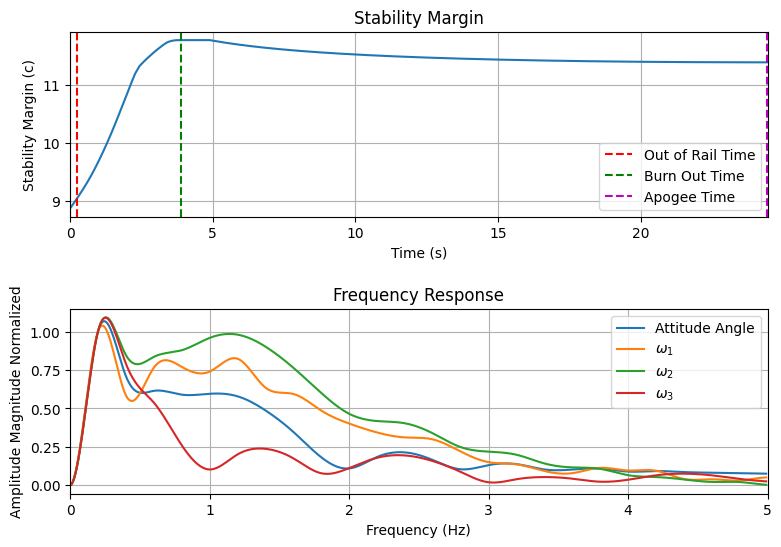



Rocket and Parachute Pressure Plots



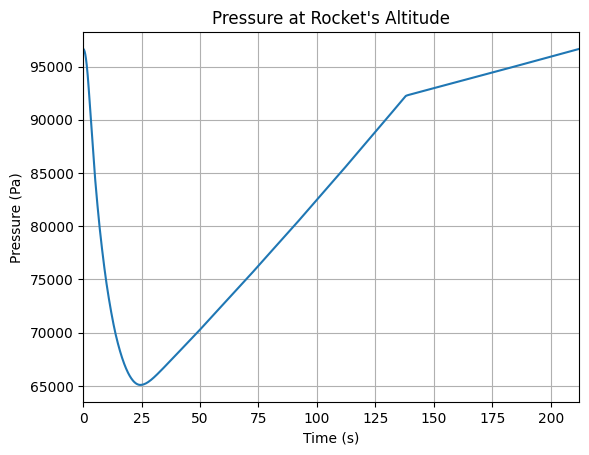


Parachute:  Main Parachute + Bag


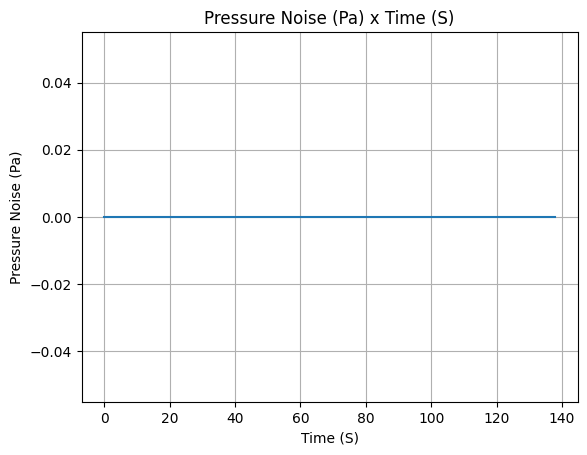

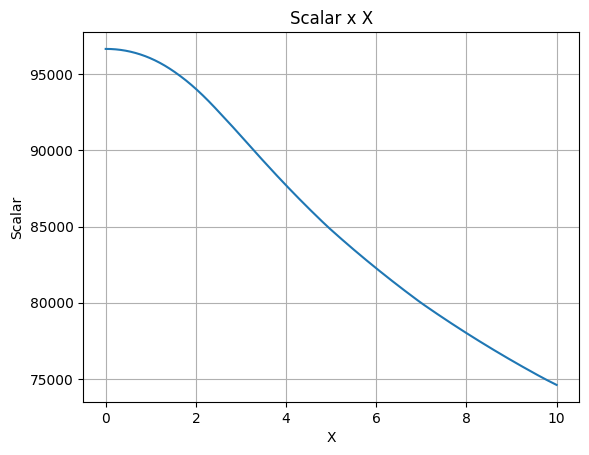

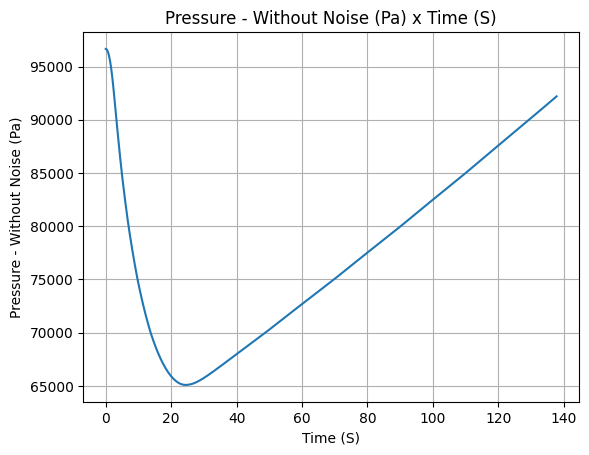


Parachute:  Drogue


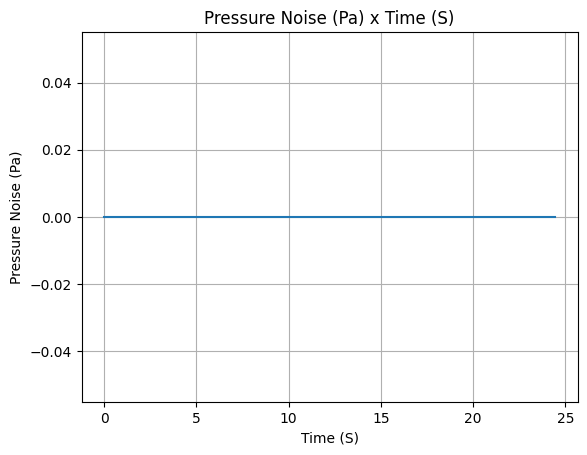

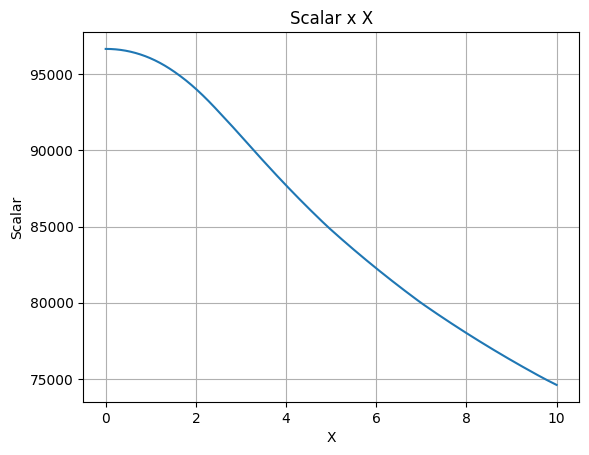

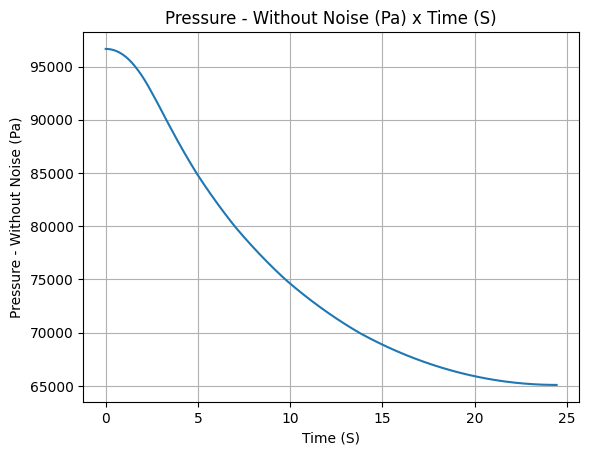

In [23]:
# Display comprehensive flight analysis including:
# - Trajectory plots (altitude, velocity, acceleration vs time)
# - Maximum values (apogee, max velocity, max acceleration)
# - Stability metrics throughout flight
# - Recovery system deployment events
# - Impact conditions and landing location
print("Flight Summary:")
flight.all_info()

In [1]:
# Quick sanity check: expected peak acceleration band (ignoring drag)
from math import pi

# Inputs from earlier cells (with safe fallbacks if this cell is run standalone)
Tmax = globals().get('Tmax', 4080.53093197668)  # N, from ENG file peak
rocket_dry_mass = globals().get('rocket_dry_mass', 17.732)  # kg (rocket structure without motor)
motor_dry_mass = globals().get('motor_dry_mass', 3.353)  # kg (motor case without propellant)
motor_grain_density = globals().get('motor_grain_density', 1137.5)  # kg/m^3
motor_grain_height = globals().get('motor_grain_height', 0.732)  # m
motor_grain_outer_radius = globals().get('motor_grain_outer_radius', 0.049)  # m
motor_grain_inner_radius = globals().get('motor_grain_inner_radius', 0.0245)  # m

# Estimate initial propellant mass from geometry and density
prop_mass_init = motor_grain_density * pi * motor_grain_height * (motor_grain_outer_radius**2 - motor_grain_inner_radius**2)

# Conservative lower/upper bounds for peak acceleration (drag ignored):
m_init = rocket_dry_mass + motor_dry_mass + prop_mass_init  # heaviest
m_end = rocket_dry_mass + motor_dry_mass                     # lightest (end of burn)
g0 = 9.80665
a_lower = (Tmax - m_init * g0) / m_init  # lower bound (heaviest)
a_upper = (Tmax - m_end * g0) / m_end    # upper bound (lightest)

print(f"Expected peak acceleration band (ignoring drag): {a_lower:.1f}–{a_upper:.1f} m/s² ({a_lower/g0:.1f}–{a_upper/g0:.1f} g)")
print("Note: Real peak will be a bit lower once drag is included. If the summary shows >> this (e.g., ~1000 m/s², ~100 g), it's a reporting artifact, not physical.")

Expected peak acceleration band (ignoring drag): 148.4–183.7 m/s² (15.1–18.7 g)
Note: Real peak will be a bit lower once drag is included. If the summary shows >> this (e.g., ~1000 m/s², ~100 g), it's a reporting artifact, not physical.


In [2]:
# Optional helper: Smooth the thrust curve to remove millisecond spikes (saves CSV)
import csv, os
import numpy as np

eng_path = os.path.join('..','..','data','AeroTech_M2500T.eng')
out_path = os.path.join('..','..','data','AeroTech_M2500T_smoothed.csv')

# Load time, thrust from .eng (tab/space separated)
t, F = [], []
with open(eng_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith(';') or line[0].isalpha():
            continue
        parts = line.replace('\t', ' ').split()
        if len(parts) >= 2:
            try:
                ti = float(parts[0]); Fi = float(parts[1])
            except ValueError:
                continue
            t.append(ti); F.append(Fi)
t = np.array(t); F = np.array(F)

# Resample to uniform dt for stable smoothing
dt = 0.005
t_uni = np.arange(t.min(), t.max(), dt)
F_uni = np.interp(t_uni, t, F)

# Apply light moving-average (window ~25 ms)
win = max(3, int(0.025/dt)) | 1  # odd window size
kernel = np.ones(win)/win
F_smooth = np.convolve(F_uni, kernel, mode='same')

# Ensure non-negative and zero tail
F_smooth = np.clip(F_smooth, 0.0, None)
if F_smooth[-1] > 0:
    F_smooth[-int(0.02/dt):] = 0.0

# Save as CSV [time, thrust]
with open(out_path, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['time_s','thrust_N'])
    w.writerows(zip(t_uni, F_smooth))
print(f"Smoothed thrust saved to {out_path} (dt={dt:.3f}s, win={win} samples)")

Smoothed thrust saved to ..\..\data\AeroTech_M2500T_smoothed.csv (dt=0.005s, win=5 samples)


In [3]:
# Optional helper: Clean a noisy Cd(Mach) curve and build RocketPy-ready arrays
import numpy as np, csv, os
from collections import defaultdict

raw_cd_path = os.path.join('..','..','serializer','v-10-jose','drag_curve.csv')
clean_cd_path = os.path.join('..','..','data','drag_curve_clean.csv')

M_list, Cd_list = [], []
with open(raw_cd_path, 'r') as f:
    for row in csv.reader(f):
        try:
            M, Cd = float(row[0]), float(row[1])
        except Exception:
            continue
        # Filter obviously bad points (tiny/huge or impossible spikes)
        if not (0.0 < M < 5.0):
            continue
        if not (0.05 <= Cd <= 1.5):  # sane bounds for typical slender HPR airframes
            continue
        M_list.append(M); Cd_list.append(Cd)

# Bin by Mach to deduplicate and median-filter
bins = defaultdict(list)
for M, Cd in zip(M_list, Cd_list):
    key = round(M, 3)  # ~0.001 Mach bins
    bins[key].append(Cd)

M_clean = sorted(bins.keys())
Cd_clean = [float(np.median(bins[m])) for m in M_clean]

# Light smooth in-place (3-pt median)
if len(Cd_clean) >= 3:
    Cd_med = Cd_clean.copy()
    for i in range(1, len(Cd_clean)-1):
        Cd_med[i] = float(np.median(Cd_clean[i-1:i+2]))
    Cd_clean = Cd_med

# Save cleaned curve
with open(clean_cd_path, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['Mach','Cd_power_off'])
    w.writerows(zip(M_clean, Cd_clean))
print(f"Cleaned Cd(Mach) saved to {clean_cd_path} with {len(M_clean)} points.")

# Build arrays for Rocket(power_off_drag=...) usage
cd_power_off = np.column_stack([M_clean, Cd_clean])
cd_power_on = np.column_stack([M_clean, np.maximum(0.0, np.array(Cd_clean) - 0.03)])  # small plume relief
print(f"cd_power_off shape: {cd_power_off.shape}, example: {cd_power_off[:5]} ")

Cleaned Cd(Mach) saved to ..\..\data\drag_curve_clean.csv with 767 points.
cd_power_off shape: (767, 2), example: [[0.007  0.131 ]
 [0.008  0.252 ]
 [0.009  0.252 ]
 [0.01   0.301 ]
 [0.011  0.1495]] 
